In [259]:
import numpy as np
import pandas as pd
import os
import math
from PIL import Image as PImage
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from PIL import ImageOps, ImageFilter
import cv2 as cv
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_validate

In [2]:
path = "D:\\PROGETTO_NUMERICAL_MODELS\\DATA\\"

In [44]:
def load_data(path, image_size=(200,200), resolution_filter=(800,800), split=True):
    ''' Function to load data from directories. It takes as input:
    1) path : principal path of the data;
    2) image_size : tuple of the desired shape of the image (input of img.resize), default = (200,200);
    3) resolution_filter : tuple of the resolution to filter images. If resolution is less than it than the image is discarded;
    4) split : boolean , if true then splitting data according to the directories (test, train, validation).
    It returns:
    1) data: dictionary["train"/"test"/"val"] : list of PilImage. If split = False then "data" is the only key of the dictionary;
    2 ) labels : dictionary["train"/"test"/"val"] : np.array of the labels for each element.
    '''
    directories = ["train", "val", "test"]
    label_dir = ["NORMAL", "PNEUMONIA"]
    if split:
        data = {x:[] for x in directories}
        labels = {x:[] for x in directories}
        for folder in data:
            for label in label_dir:
                path_tp = path + folder + "\\" + label
                files = os.listdir(path_tp)
                for file in files:
                    img = PImage.open(path_tp + "\\" + file)
                    if np.array(img).shape[0] >= resolution_filter[0] and np.array(img).shape[1] >= resolution_filter[1]:
                        img = img.resize(image_size)
                        data[folder].append(img)
                        labels[folder].append(label)
    else:
        data = {"data": []}
        labels = {"data": []}
        for folder in directories:
            for label in label_dir:
                path_tp = path + folder + "\\" + label
                files = os.listdir(path_tp)
                for file in files:
                    img = PImage.open(path_tp + "\\" + file)
                    if np.array(img).shape[0] >= resolution_filter[0] and np.array(img).shape[1] >= resolution_filter[1]:
                        img = img.resize(image_size)
                        data["data"].append(img)
                        labels["data"].append(label)
    labels_arr = {x: 0 for x in labels}
    for folder in labels_arr:
        labels_arr[folder] = np.array(labels[folder])
    return data, labels_arr

In [265]:
# To show an image
img =  PImage.open( "D:\\PROGETTO_NUMERICAL_MODELS\\DATA\\train\\NORMAL\\IM-0115-0001.jpeg")
img_arr = np.array(img)
img_arr.shape
img.show()
img.resize((64,64)).show()

In [45]:
data, labels = load_data(path,image_size = (200,200),  resolution_filter = (1200,1200), split = False)
# If we want to split as the directories do
#data, labels = load_data(path,image_size = (200,200),  resolution_filter = (1200,1200))

In [49]:
def from_image_to_number(data):
    ''' Function that trasform Pil image in np.array. It takes as input:
    1) data: in the format of load_data output.
    It returns:
    1) data_numeric:dictionary of the same type of data but with numpy matrices in place of Pilimages. 
    '''
    data_numeric = {x:[] for x in data}
    for folder in data:
        for img in data[folder]:
            data_numeric[folder].append(np.array(img))
    return data_numeric        

In [50]:
def from_number_to_image(data_numeric):
    '''
    Function that do the reverse of from_image_to_number function
    '''
    data_image  = {x:[] for x in data_numeric}
    for folder in data_numeric:
        for img in data_numeric[folder]:
            data_image[folder].append(PImage.fromarray(img))
    return data_image            

In [51]:
data_numeric = from_image_to_number(data)

In [52]:
def equalize_data(data):
    ''' Function to apply histogram equalizer on data. It takes as input:
    1) data: in the format of load_data output;
    It returns :
    1) equalized_data: dictionary of the same type of data but with equalized Pilimages in place of Pilimages.
    '''
    equalized_data = {x:[] for x in data}
    for folder in data:
        for img in data[folder]:
            equalized_data[folder].append(ImageOps.equalize(img, mask = None))
    return equalized_data

In [53]:
equalized_data = equalize_data(data)

In [54]:
def blur_gaussian(data, radius = 2):
     ''' Function to apply Gaussian Blur on data. It takes as input:
    1) data: in the format of load_data output;
    2) radius: radius of Gaussian Blur kernel.
    It returns :
    1) blurred_data: dictionary of the same type of data but with blurred Pilimages in place of Pilimages.
    '''
    blurred_data = {x:[] for x in data}
    for folder in data:
        for img in data[folder]:
            blurred_data[folder].append(img.filter(ImageFilter.GaussianBlur(radius = radius)))
    return blurred_data    

In [55]:
blurred_data = blur_gaussian(data)

In [56]:
def bilateral_filter(data, diameter = 5, sigma_color = 75, sigma_space = 75):
    ''' Function to apply bilateral filter on data. It takes as input:
    1) data: in the format of load_data output;
    2) diameter, sigma_color, sigma_space: float, parameters of the filter.
    It returns :
    1) bilateral_filtered_data: dictionary of the same type of data but with bilateral filtered Pilimages in place of Pilimages.
    '''
    bilateral_filtered_data = {x:[] for x in data}
    data_numeric = from_image_to_number(data)
    for folder in data_numeric:
        for img in data_numeric[folder]:
            bilateral_filtered_data[folder].append(cv.bilateralFilter(img,diameter,sigma_color,sigma_space))
    bilateral_filtered_data =  from_number_to_image(bilateral_filtered_data)  
    return bilateral_filtered_data    

In [219]:
def save_filtered_images(path_image, label = "Normal"):
    ''' Function to save filtered images
    '''
    img = PImage.open(path_image)
    img.save("Example "+ label+".jpeg")
    img = img.resize((200,200))
    img.save("Example resized (200,200)  "+ label+".jpeg")
    ImageOps.equalize(img,mask = None).save("Example "+ label+" histogram equalizer"+".jpeg")
    img.filter(ImageFilter.GaussianBlur(radius = 2)).save("Example "+ label+" Gaussian_Bluer diameter =5"+".jpeg")
    ImageOps.equalize(img,mask = None).filter(ImageFilter.GaussianBlur(radius = 2)).save("Example "+ label+" Gaussian_Blur diameter =5 + Equalizer"+".jpeg")   

In [272]:
# To run one tome to save images
'''
path_normal = "D:\\PROGETTO_NUMERICAL_MODELS\\DATA\\train\\NORMAL\\IM-0115-0001.jpeg"
path_pneumonia = "D:\\PROGETTO_NUMERICAL_MODELS\\DATA\\train\\PNEUMONIA\\person21_bacteria_73.jpeg"
save_filtered_images(path_normal)
save_filtered_images(path_pneumonia, label = "PNEUMONIA")
'''

In [57]:
bilateral_filtered_data = bilateral_filter(data)

In [58]:
def flatten_data(data_numeric):
    ''' Function to flatten data. It takes as input:
    1) data_numeric: as the output of from_image_to_number function.
    It returns:
    1) flattened_data_1 = dictionary of the same type of data but with matrices in place of Pilimages.
    '''
    flattened_data = {x: [] for x in data_numeric}
    for folder in data_numeric:
        for img in data_numeric[folder]:
            flattened_data[folder].append(np.reshape(img, (img.shape[0] * img.shape[1])))
    flattened_data_1 = {x: 0 for x in data_numeric}
    for folder in flattened_data_1:
        flattened_data_1[folder] =  np.vstack(flattened_data[folder])
    return flattened_data_1

In [59]:
flattened_data = flatten_data(data_numeric)
flattened_data["data"].shape

In [64]:
X_train, X_test, y_train, y_test = train_test_split(flattened_data["data"], labels["data"],test_size=0.20, random_state=42,
                                                    shuffle = True)

In [67]:
print("Number of training examples is :",X_train.shape[0])
print("Number of test examples is :",X_test.shape[0])

Number of training examples is : 1144
Number of test examples is : 286


In [68]:
unique, counts = np.unique(y_train,return_counts=True)
print("-------------------TRAINING SET CLASS SPLITTING----------------------")
print(unique)
print(counts)
unique1, counts1 = np.unique(y_test,return_counts=True)
print("-------------------TESTING SET CLASS SPLITTING----------------------")
print(unique1)
print(counts1)

-------------------TRAINING SET CLASS SPLITTING----------------------
['NORMAL' 'PNEUMONIA']
[833 311]
-------------------TESTING SET CLASS SPLITTING----------------------
['NORMAL' 'PNEUMONIA']
[211  75]


In [108]:
###############################

In [23]:
'''
print("Number of training examples is :", len(data["train"]))
print("Number of validation examples is :", len(data["val"]))
print("Number of test examples is :", len(data["test"]))
unique, counts = np.unique(np.array(labels["test"]),return_counts=True)
print(unique)
print(counts)
'''

Number of training examples is : 1274
Number of validation examples is : 4
Number of test examples is : 152


In [ ]:
#############################

In [69]:
data_equalized_flattened = flatten_data(from_image_to_number(equalized_data))

In [93]:
X_train, X_test, y_train, y_test = train_test_split(data_equalized_flattened["data"], labels["data"],test_size=0.20, random_state=42,
                                                    shuffle = True)

In [227]:
unique_train, counts_train = np.unique(y_train,return_counts=True)
print("-------------------TRAINING SET CLASS SPLITTING----------------------")
print(unique_train)
print(counts_train)
unique_test, counts_test = np.unique(y_test,return_counts=True)
print("-------------------TESTING SET CLASS SPLITTING----------------------")
print(unique_test)
print(counts_test)

-------------------TRAINING SET CLASS SPLITTING----------------------
['NORMAL' 'PNEUMONIA']
[833 311]
-------------------TESTING SET CLASS SPLITTING----------------------
['NORMAL' 'PNEUMONIA']
[211  75]


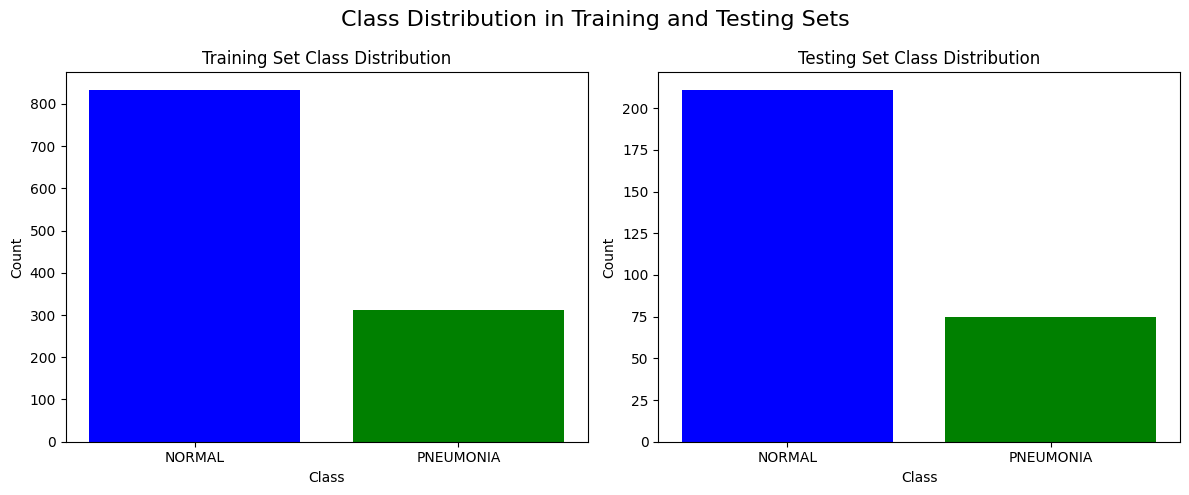

In [230]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(unique_train, counts_train, color=['blue', 'green'])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticks(unique_train)
axes[0].set_xticklabels(unique_train)

axes[1].bar(unique_test, counts_test, color=['blue', 'green'])
axes[1].set_title('Testing Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticks(unique_test)
axes[1].set_xticklabels(unique_test)

fig.suptitle('Class Distribution in Training and Testing Sets', fontsize=16)

plt.tight_layout()
plt.show()

fig.savefig("class_distribution.jpeg")

In [116]:
model = SVC(kernel = "rbf", C = 20, gamma = "auto")

In [117]:
X_train_scaled = (1/255)* X_train
X_test_scaled = (1/255) * X_test

In [118]:
model.fit(X_train_scaled,y_train)

SVC(C=20, gamma='auto')

In [119]:
# Accuracy
print( "Accuracy on test set : ",model.score(X_test_scaled,y_test))
print( "Accuracy on train set : ", model.score(X_train_scaled,y_train))

0.9125874125874126

In [144]:
def evaluate_model( data,labels, C_vector, gamma_vector, 
                   filters = ["histogram_equalizer", "Gaussian_Blur", "Bilateral_Filter","equalizer + Gaussian Blur"],
                   radius_Gaussian_Blur = 2,  
                   diameter = 5, sigma_color = 75, sigma_space = 75):
    ''' Function to detect best C and gamma parameter for Gaussian kernel. It takes as input:
    1) data: dictionary as the output of load_data function;
    2) labels : dictionary as the output of load_data_function;
    3) filters: list of fliter to take into account (only filter in default:filters are allowed);
    4) radius_Gaussian_Blur: radius for Gaussian blur (default = 2);
    5) diameter, sigma_color, sigma_space: float, parameters of the bilateral filter (default = 5,75,75).
    It returns:
    1) accuracy_on_test : dictionary of surfaces values where accuray_on_test[filter] = matrix where matrix_ij = accuracy(C = C_vector[i], 
    gamma = gama_vector[j]) for the correspondig filter.
    '''
    accuracy_on_test = {x:0 for x in filters}
    for filter in filters:
        print("Applying filter :",filter)
        if filter == "histogram_equalizer":
            data_filtered = flatten_data(from_image_to_number(equalize_data(data)))
            X_train, X_test, y_train, y_test = train_test_split(data_filtered["data"], labels["data"],test_size=0.20, random_state=42,
                                                    shuffle = True)
            surface = np.zeros((len(C_vector),len(gamma_vector)))
            X_train_scaled = (1/255)* X_train
            X_test_scaled = (1/255) * X_test
            for i in range(len(C_vector)):
                for j in range(len(gamma_vector)):
                    print("iteration C = ",C_vector[i]," gamma = ", gamma_vector[j])
                    model = SVC(kernel = "rbf", C = C_vector[i], gamma = gamma_vector[j])
                    model.fit(X_train_scaled, y_train)
                    surface[i,j] = model.score(X_test_scaled,y_test)
            accuracy_on_test[filter] = surface
        elif filter == "Gaussian_Blur":
            data_filtered = flatten_data(from_image_to_number(blur_gaussian(data, radius = radius_Gaussian_Blur )))
            X_train, X_test, y_train, y_test = train_test_split(data_filtered["data"], labels["data"],test_size=0.20, random_state=42,
                                                    shuffle = True)
            surface = np.zeros((len(C_vector),len(gamma_vector)))
            X_train_scaled = (1/255)* X_train
            X_test_scaled = (1/255) * X_test
            for i in range(len(C_vector)):
                for j in range(len(gamma_vector)):
                    print("iteration C = ",C_vector[i]," gamma = ", gamma_vector[j])
                    model = SVC(kernel = "rbf", C = C_vector[i], gamma = gamma_vector[j])
                    model.fit(X_train_scaled, y_train)
                    surface[i,j] = model.score(X_test_scaled,y_test)
            accuracy_on_test[filter] = surface
        elif filter == "Bilateral_Filter":
            data_filtered = flatten_data(from_image_to_number(bilateral_filter(data, diameter = diameter, 
                                                                                sigma_color = sigma_color, sigma_space = sigma_space)))
            X_train, X_test, y_train, y_test = train_test_split(data_filtered["data"], labels["data"],test_size=0.20, random_state=42,
                                                    shuffle = True)
            surface = np.zeros((len(C_vector),len(gamma_vector)))
            X_train_scaled = (1/255)* X_train
            X_test_scaled = (1/255) * X_test
            for i in range(len(C_vector)):
                for j in range(len(gamma_vector)):
                    print("iteration C = ",C_vector[i]," gamma = ", gamma_vector[j])
                    model = SVC(kernel = "rbf", C = C_vector[i], gamma = gamma_vector[j])
                    model.fit(X_train_scaled, y_train)
                    surface[i,j] = model.score(X_test_scaled,y_test)
            accuracy_on_test[filter] = surface
        elif filter == "equalizer + Gaussian Blur":
            data_filtered = flatten_data(from_image_to_number(blur_gaussian(equalize_data(data), radius = radius_Gaussian_Blur)))
            X_train, X_test, y_train, y_test = train_test_split(data_filtered["data"], labels["data"],test_size=0.20, random_state=42,
                                                    shuffle = True)
            surface = np.zeros((len(C_vector),len(gamma_vector)))
            X_train_scaled = (1/255)* X_train
            X_test_scaled = (1/255) * X_test
            for i in range(len(C_vector)):
                for j in range(len(gamma_vector)):
                    print("iteration C = ",C_vector[i]," gamma = ", gamma_vector[j])
                    model = SVC(kernel = "rbf", C = C_vector[i], gamma = gamma_vector[j])
                    model.fit(X_train_scaled, y_train)
                    surface[i,j] = model.score(X_test_scaled,y_test)
            accuracy_on_test[filter] = surface
                         
    return accuracy_on_test                        

In [ ]:
C_vector = np.linspace(1,30, num = 10)
gamma_vector = np.linspace(1/80000, 1/20000, num = 10)

In [145]:
# Run this secotion only one time (loaded after)
'''
results =  evaluate_model( data,labels, C_vector, gamma_vector, 
                   filters = ["histogram_equalizer", "Gaussian_Blur"],
                   radius_Gaussian_Blur = 2,  
                   diameter = 5, sigma_color = 75, sigma_space = 75)
'''

Applying filter : histogram_equalizer
iteration C =  1.0  gamma =  1e-05
iteration C =  1.0  gamma =  2.5e-05
iteration C =  30.0  gamma =  1e-05
iteration C =  30.0  gamma =  2.5e-05
Applying filter : Gaussian_Blur
iteration C =  1.0  gamma =  1e-05
iteration C =  1.0  gamma =  2.5e-05
iteration C =  30.0  gamma =  1e-05
iteration C =  30.0  gamma =  2.5e-05


In [165]:
# Loading results
# surfaces[i,j,z] = accuracy(C_vector[i],gamma_vector[j],filters[z])
filters = ["histogram_equalizer", "Gaussian_Blur", "Bilateral_Filter","equalizer + Gaussian Blur"]
surfaces = np.load("surfaces.npy")

In [293]:
def plot_results_models(C_vector, gamma_vector, surfaces ,
                        filters = ["histogram_equalizer", "Gaussian_Blur", "Bilateral_Filter","equalizer + Gaussian Blur"],
                       save_path = False):
    ''' Function to plot surfaces. It takes as input:
    1) C_vector: numpy array of values of parameter C;
    2) gamma_vector: numpy array of values of parameter gamma;
    3) surfaces : numpy array where surfaces[:,:,i] is the correspondig sufacce for the corresponding filter = filters[i] 
    4) filters : list of filters applied ( it should be len(filters) = surfaces.shape[2];
    5) save_path : file_name  to save the plot. Dafault = False, it does not save the plot.
    It plots the surfaces on the same plot
    '''
    fig, axes = plt.subplots(2, len(filters) // 2, subplot_kw={'projection': '3d'}, figsize=(15, 12))
    X, Y = np.meshgrid(C_vector, gamma_vector)
    for i in range(len(filters)):
        row = i // (len(filters) // 2)
        col = i % (len(filters) // 2)
        ax = axes[row, col]
        ax.plot_surface(X, Y, surfaces[:, :, i], cmap='viridis')
        ax.set_title(f"Applied {filters[i]}")
        ax.set_xlabel('C')
        ax.set_ylabel('Gamma')
        ax.set_zlabel('Accuracy on test set')
    fig.suptitle('Surface Plots for Different Filters', fontsize=16)
    plt.tight_layout()
    plt.show()
    if save_path:
        fig.savefig(save_path)  

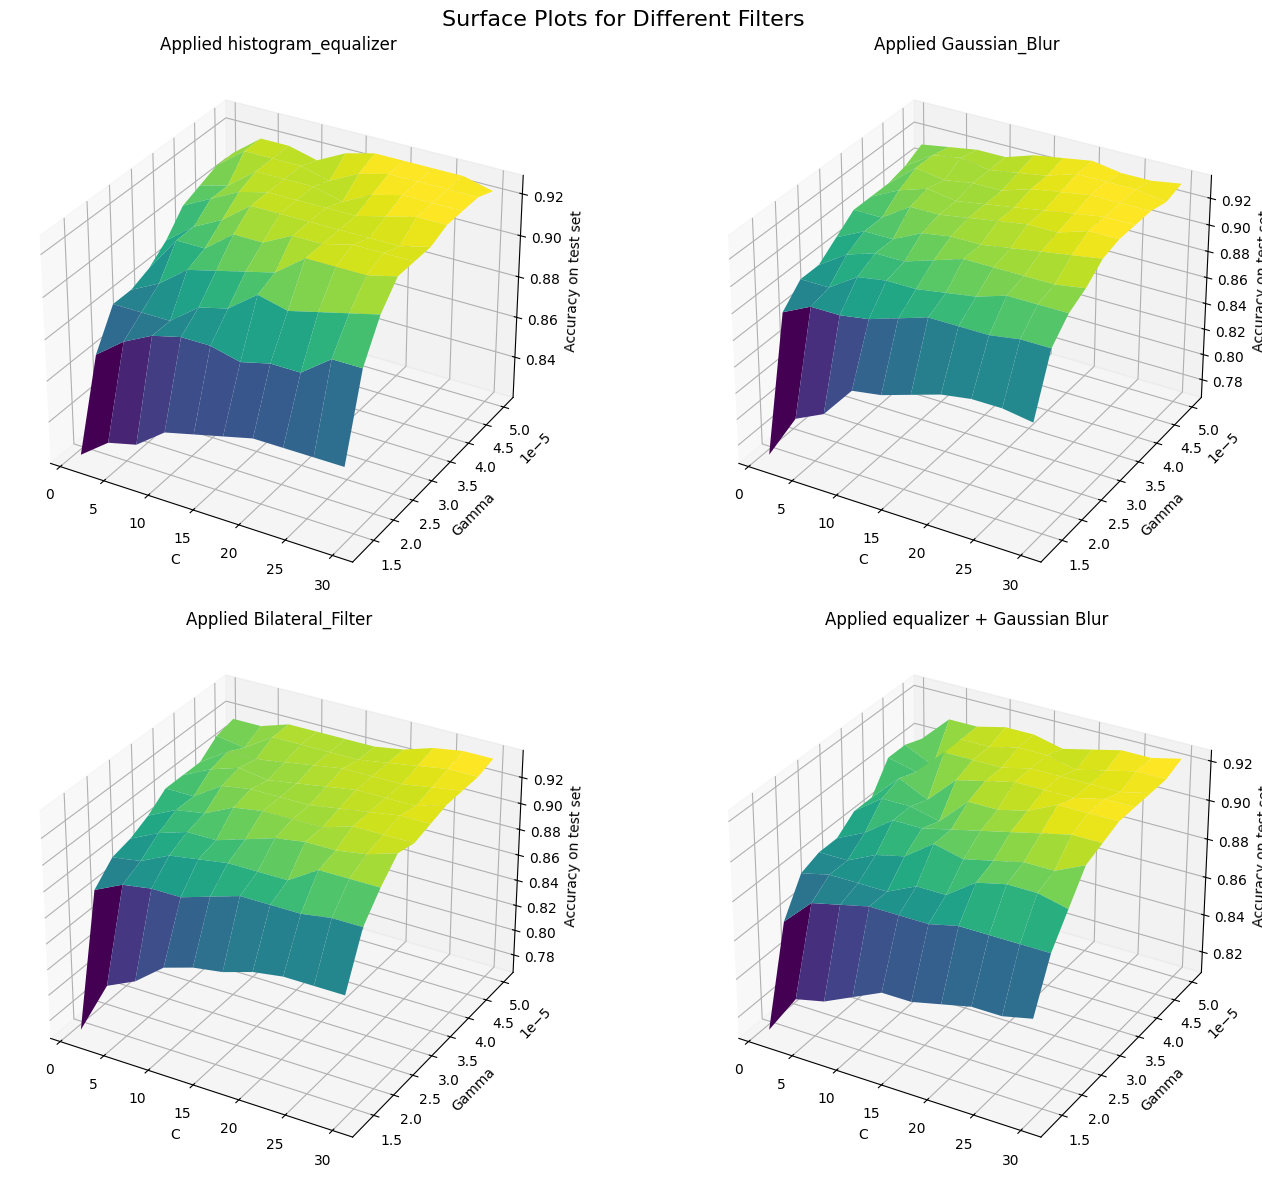

In [177]:
C_vector = np.linspace(1,30, num = 10)
gamma_vector = np.linspace(1/80000, 1/20000, num = 10)

plot_results_models(C_vector = C_vector, gamma_vector = gamma_vector, surfaces = surfaces,
                   save_path = "surfaces.jpeg")

In [245]:
def plot_confusion_matrix(model, X_test, y_test, image_path = False):
    '''Function to plot the confusion matrix. It takes as input:
    1) model : fitted model (sklearn model);
    2) X_test : testing data (matrix of testing data);
    3) y_test : numpy array of the labels for X_test;
    4) image_path : file_name  to save the plot. Dafault = False, it does not save the plot.
    '''
    fig, ax = plt.subplots(figsize=(10, 8))
    cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax,
                                                       colorbar=False, cmap="viridis_r")
    ax.set_title("Confusion Matrix", fontsize=18)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    if image_path:
        plt.savefig(image_path)
    plt.show()   

In [237]:
# Positive = PNEUMONIA
# Negative = NORMAL
def compute_performance_metrics(model,X_test, y_test):
    ''' Function to compute classical performance measures. It takes as input:
    1) model : sklearn fitted model;
    2) X_test : testing data (matrix of testing data);
    3) y_test : numpy array of the labels for X_test.
    It returns the following performance measures:
    1) accuracy;
    2) precision;
    3) recall;
    4) F1-score.
    '''
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test,y_test)
    precision, recall,f_beta_score, support = precision_recall_fscore_support(y_test, y_pred)
    return accuracy,precision[1], recall[1], f_beta_score[1]

In [ ]:
############################################################## BEST MODEL #######################################################

In [236]:
filter_best = "bilateral_filter"
data_filtered = flatten_data(from_image_to_number(bilateral_filter(data, diameter = 5, 
                                                                    sigma_color = 75, sigma_space = 75)))
X_train, X_test, y_train, y_test = train_test_split(data_filtered["data"], labels["data"],test_size=0.20, random_state=42,
                                                    shuffle = True)
X_train = (1/255) * X_train
X_test = (1/255) * X_test

In [238]:
C_best = C_vector[9]
gamma_best = gamma_vector[8]
best_model =  SVC(kernel = "rbf", C = C_best, gamma = gamma_best)
best_model.fit(X_train, y_train)

SVC(C=30.0, gamma=4.5833333333333334e-05)

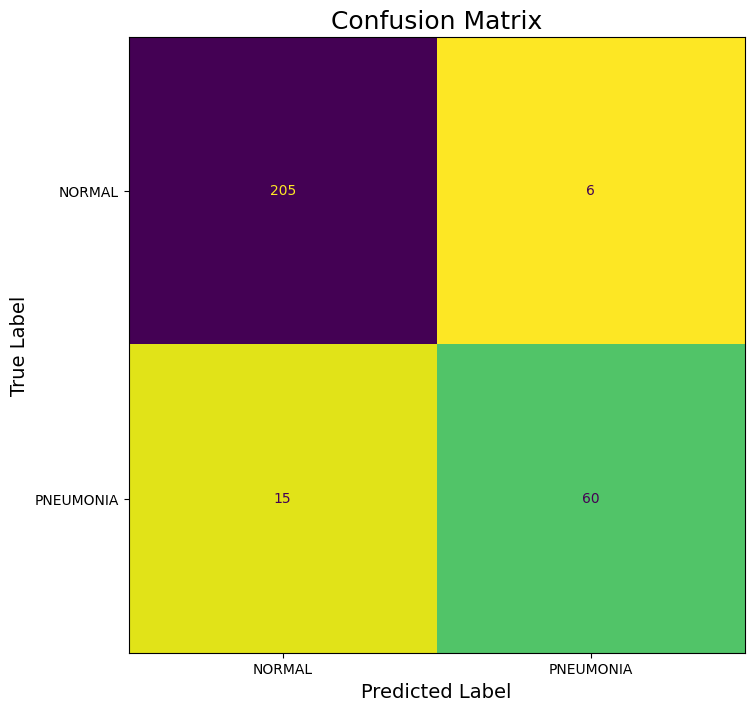

In [248]:
#plot_confusion_matrix(best_model, X_test, y_test, image_path = "confusion_matrix.jpeg")
plot_confusion_matrix(best_model, X_test, y_test)

In [240]:
accuracy,precision, recall, f_beta_score = compute_performance_metrics(best_model, X_test, y_test)
print(f"Accuracy on test set = {accuracy}") 
print("-----------------------------------")
print(f"Precision on test set = {precision}") 
print("-----------------------------------")
print(f"Recall on test set = {recall}")
print("-----------------------------------")
print(f"F-1 score on test set = {f_beta_score}")

Accuracy on test set = 0.9265734265734266
-----------------------------------
Precision on test set = 0.9090909090909091
-----------------------------------
Recall on test set = 0.8
-----------------------------------
F-1 score on test set = 0.851063829787234


In [ ]:
########################################################### CROSS-VALIDATION ###################################################

In [249]:
data_filtered = flatten_data(from_image_to_number(bilateral_filter(data, diameter = 5, 
                                                                    sigma_color = 75, sigma_space = 75)))
X = (1/255) * data_filtered["data"]

In [264]:
y = np.where(labels["data"] == "NORMAL", 0,1)
res_cross_val =  cross_validate(best_model, X,  labels["data"], cv=10,
                        scoring=('accuracy','precision','recall' ,'f1'),
                        return_train_score=False)

In [286]:
cross_val = pd.DataFrame(res_cross_val)
cross_val.index = [f"{i+1} fold" for i in range(len(cross_val))]
cross_val.loc['Mean results'] = mean_res
cross_val

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1 fold,18.882835,3.707422,0.923077,0.909091,0.789474,0.845070
2 fold,18.327481,4.841672,0.965035,1.000000,0.868421,0.929577
3 fold,18.717432,3.982299,0.944056,0.941176,0.842105,0.888889
4 fold,16.028239,3.645625,0.958042,0.970588,0.868421,0.916667
5 fold,16.654617,3.758519,0.937063,0.916667,0.846154,0.880000
6 fold,17.278660,3.559622,0.923077,0.868421,0.846154,0.857143
7 fold,17.323133,3.729944,0.958042,0.971429,0.871795,0.918919
8 fold,16.587952,3.731243,0.916084,0.885714,0.794872,0.837838
9 fold,16.173955,3.772663,0.902098,0.820513,0.820513,0.820513
10 fold,15.217180,3.516932,0.839161,0.666667,0.820513,0.735632
